# Вольный луг

**Исходные данные**

Файл *ferma_main.csv* содержит данные о стаде фермера на текущий момент. Описание таблицы:
- Параметры корма коровы
-- ЭКЕ (Энергетическая кормовая единица) — измерение питательности корма коровы;
-- Сырой протеин — содержание сырого протеина в корме, в граммах;
-- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
- Где паслась корова
-- Тип пастбища — ландшафт лугов, на которых паслась корова.
- Особенности коровы
-- id — номер коровы;
-- Порода — порода коровы;
-- Возраст — бинарный признак (менее_2_лет, более_2_лет);
-- Имя Папы — порода папы коровы.
- Характеристики молока
-- Жирность — содержание жиров в молоке, в процентах;
-- Белок — содержание белков в молоке, в процентах;
-- Вкус молока — оценка вкуса по личным критериям фермера;
-- Удой — масса молока, которую корова даёт в год, в килограммах.
Файл *ferma_dad.csv* хранит имя папы каждой коровы в стаде фермера.
Файл *cow_buy.csv* — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична ferma_main.csv, кроме нескольких особенностей:
-- Белок и Жирность молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
-- Параметры кормления ЭКЕ, Сырой протеин, СПО отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. 
-- По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.

**Цель исследования:**

Создать модель, которая поможет фермеру принимать верное решение о покупке коровы. Необходимо, чтобы модель отбирала коров, которые дадут не менее 6000 кг. вкусного молока в год.

**Ход работы:**
<ul>
    <li><a href='#getting'>Загрузка данных</a></li>
    <li>
        <a href='#exploration'>Исследование данных</a>
        <ul>
            <li><a href='#double'>Выявление дублей и их обработка</a></li>
            <li><a href='#graphs'>Оценка распределений признаков</a></li>
            <li><a href='#corr'>Корреляционный анализ для выявления зависимостей</a></li>
        </ul>
    </li>
    <li><a href='#processing'>Предобработка данных</a></li>
    <li><a href='#feature'>Feature Engineering</a></li>
    <li><a href='#linreg'>Обучение и настройка модели линейной регрессии для предсказания удоев</a></li>
    <li><a href='#logreg'>Обучение и настройка модели логистической регрессии для предсказание вкусного молока</a></li>
    <li><a href='#summary'>Общий вывод</a></li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

In [2]:
def drop_duplicates(df):
    '''Показывает количество дубликатов и при необходимости удаляет'''
    duplicated = df.duplicated().sum()
    print(f'Найдено {duplicated} дублей')
    if duplicated > 0:
        df = df.drop_duplicates()
        duplicated = df.duplicated().sum()
        print(f'После удаления осталось {duplicated} дублей')
    return df


def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    f.suptitle(title, fontsize=20)
    ax1.boxplot(df[variable])
    ax1.set_title('Ящик с усами')
    ax1.set_xlabel(xlabel)
    ax1.set_xticks([])

    ax2.hist(df[variable], bins=bins)
    ax2.set_title('Гистограмма')
    ax2.set_xlabel(xlabel)

    plt.show()

<a id='getting'></a>
## Загрузка данных

In [3]:
main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
cow = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [4]:
# В целях оптимизации сделаем один словарь для переименования всех возможных колонок
possible_columns = {
    'Удой, кг': 'milk_kg',
    'ЭКЕ (Энергетическая кормовая единица)': 'eke',
    'Сырой протеин, г': 'protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'spo',
    'Порода': 'cow_breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Жирность,%': 'fat_share',
    'Текущая_жирность,%': 'fat_share',
    'Белок,%': 'protein_share',
    'Текущий_уровень_белок,%': 'protein_share',
    'Вкус молока': 'taste',
    'Возраст': 'age',
    'Имя Папы': 'dad_name',
    'Имя_папы': 'dad_name',
}

main.rename(columns=possible_columns, inplace=True)
dad.rename(columns=possible_columns, inplace=True)
cow.rename(columns=possible_columns, inplace=True)

<a id='exploration'></a>
## Исследование данных

### Предобработка main

In [5]:
main.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [6]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int64  
 1   milk_kg        634 non-null    int64  
 2   eke            634 non-null    float64
 3   protein_g      634 non-null    int64  
 4   spo            634 non-null    float64
 5   cow_breed      634 non-null    object 
 6   pasture_type   634 non-null    object 
 7   dad_breed      634 non-null    object 
 8   fat_share      634 non-null    float64
 9   protein_share  634 non-null    float64
 10  taste          634 non-null    object 
 11  age            634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [7]:
# Видно, что пропусков нет. Все колонки нужного типа данных. Проверим наличие дубликатов и удалим при необходимости
main = drop_duplicates(main).reset_index().drop(['index'], axis=1)

Найдено 5 дублей
После удаления осталось 0 дублей


### Предобработка dad

In [8]:
dad.head()

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [9]:
dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [10]:
# Видно, что пропусков нет. Все колонки нужного типа данных. Проверим наличие дубликатов и удалим при необходимости
dad = drop_duplicates(dad)

Найдено 0 дублей


### Предобработка cow

In [11]:
cow.head()

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [12]:
cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cow_breed      20 non-null     object 
 1   pasture_type   20 non-null     object 
 2   dad_breed      20 non-null     object 
 3   dad_name       20 non-null     object 
 4   fat_share      20 non-null     float64
 5   protein_share  20 non-null     float64
 6   age            20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [13]:
# Видно, что пропусков нет. Все колонки нужного типа данных. Проверим наличие дубликатов и удалим при необходимости
cow = drop_duplicates(cow).reset_index().drop(['index'], axis=1)

Найдено 4 дублей
После удаления осталось 0 дублей


Можно заметить, что тип пастбища в датасете main написан с прописной буквы, а в датасете cow - строчными. Приведём колонку к строчным

In [14]:
main['pasture_type'] = main['pasture_type'].str.lower()

**Промежуточный вывод**

Мы проверили данные на явные дубликаты и пропуски. Оценили размер датасета и типы данных. 
Можно сказать, что мы располагаем достаточно качественными полными данными. 

<a id='graphs'></a>
## Исследовательский анализ данных

### main - категориальные признаки

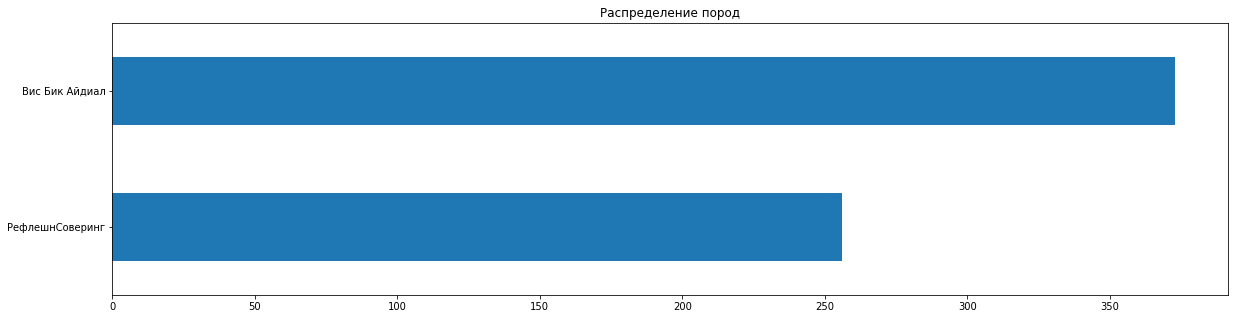

Неравномерно представлено всего две породы


In [15]:
main['cow_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пород')
plt.show()
print('''Неравномерно представлено всего две породы''')

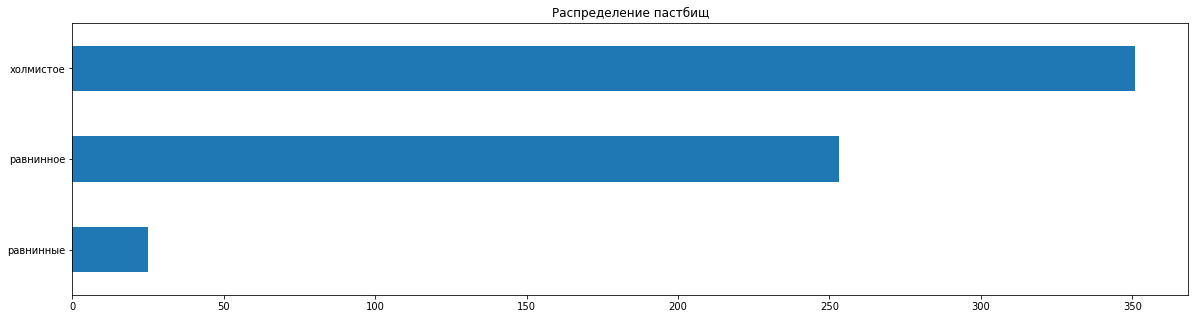

Чаще всего коров пасут на холмистой местности. 
Также видно неявный дубль равнинной местности. Его стоит перезаписать


In [16]:
main['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()
print(
    '''Чаще всего коров пасут на холмистой местности. 
Также видно неявный дубль равнинной местности. Его стоит перезаписать'''
)

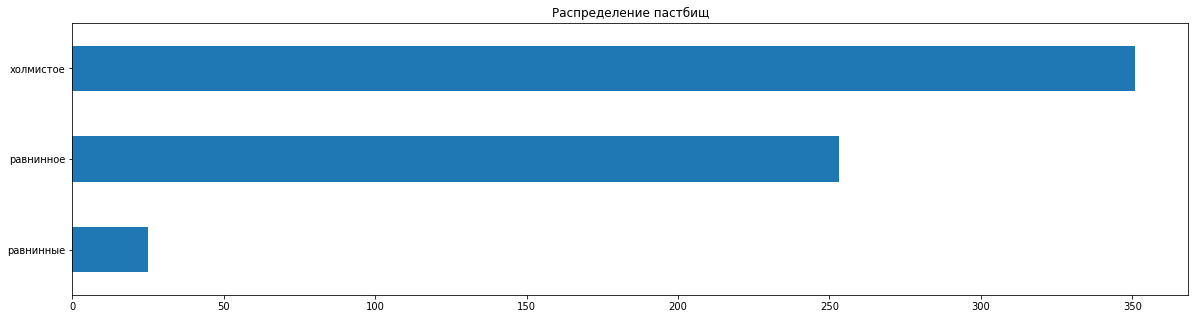

In [17]:
main['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()

Нашлись неявные дубли. Можно их преобразовать.

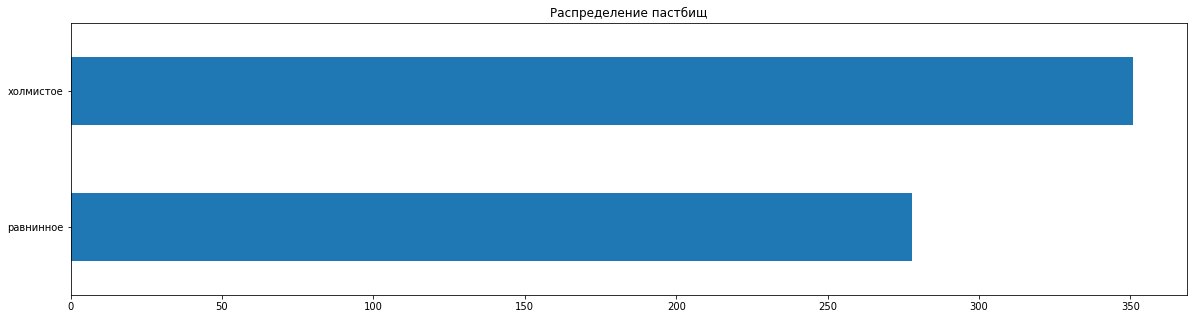

In [18]:
main = main.replace('равнинные', 'равнинное')
main['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()

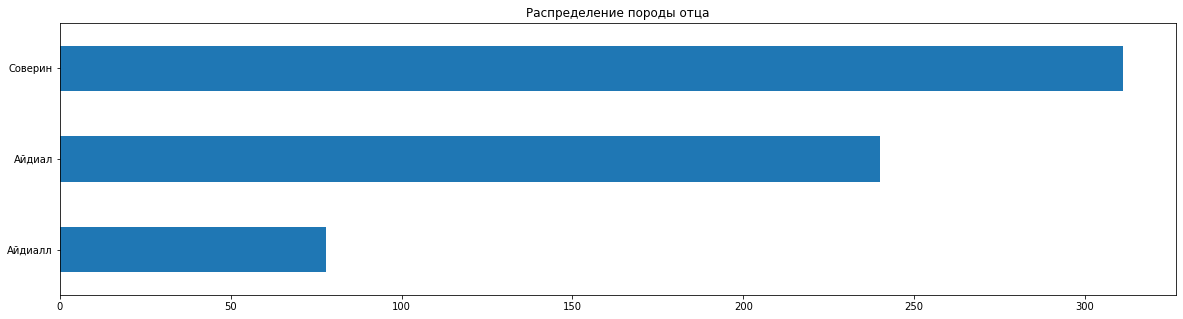

И тут не всё в порядке. Заменим


In [19]:
main['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()
print('''И тут не всё в порядке. Заменим''')

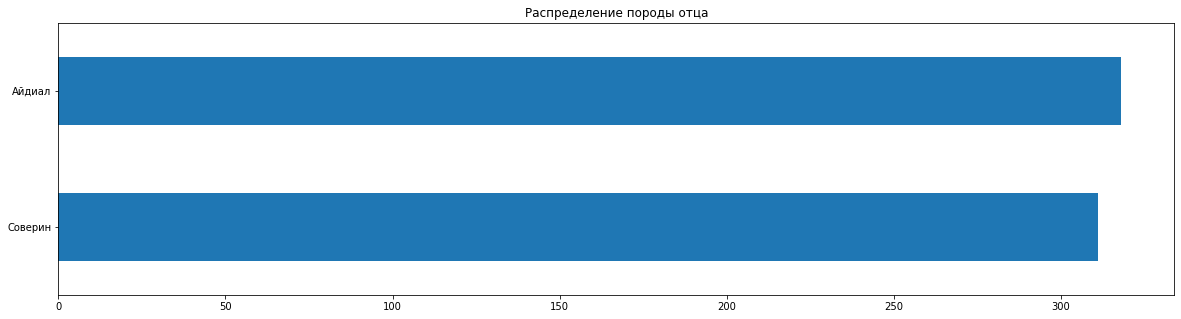

Айдиала стало даже немного больше


In [20]:
main = main.replace('Айдиалл', 'Айдиал')
main['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()
print('''Айдиала стало даже немного больше''')

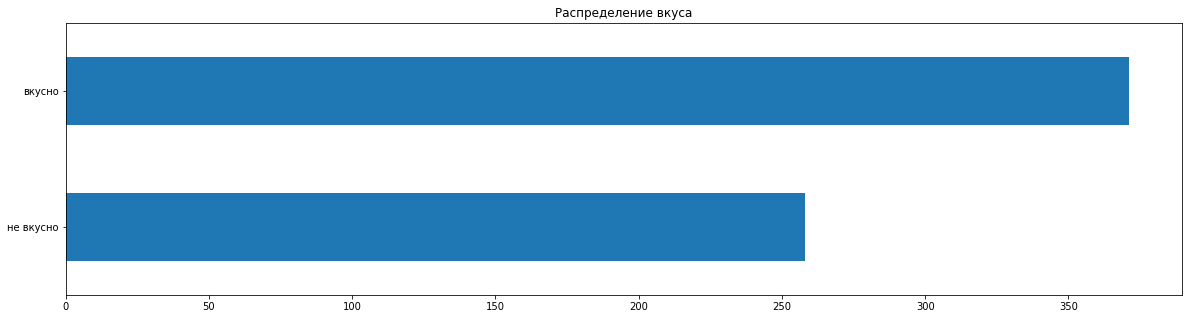

Вкусное молоко встречается чаще


In [21]:
main['taste'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение вкуса')
plt.show()
print('''Вкусное молоко встречается чаще''')

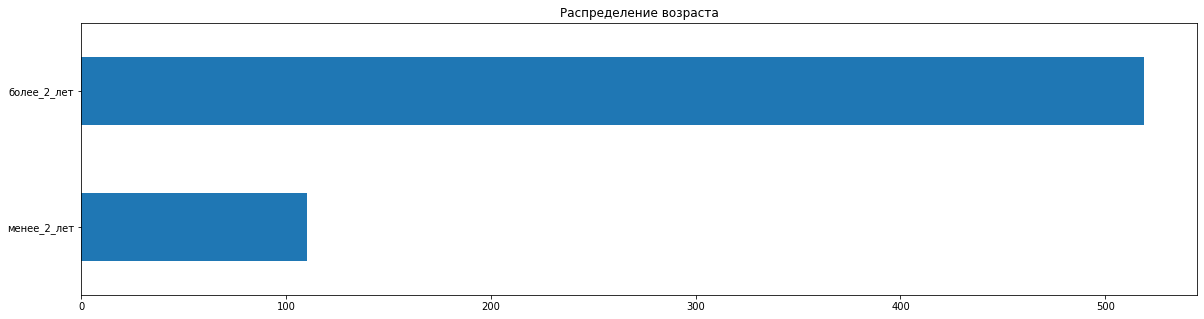

Юных коров сильно меньше


In [22]:
main['age'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение возраста')
plt.show()
print('Юных коров сильно меньше')

### main - количественные признаки признаки

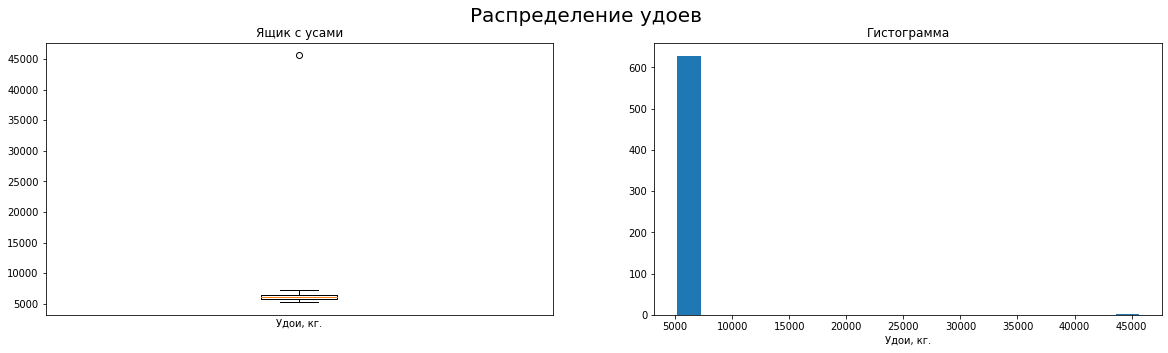

In [23]:
plot_numeric(main, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

Налицо сильные выборсы. Выглядит так, будто они указан в граммах, а не килограммах. Лучше их удалить, чем изменять, основываясь на догадках.

In [24]:
main = main[main['milk_kg'] <= 15000]

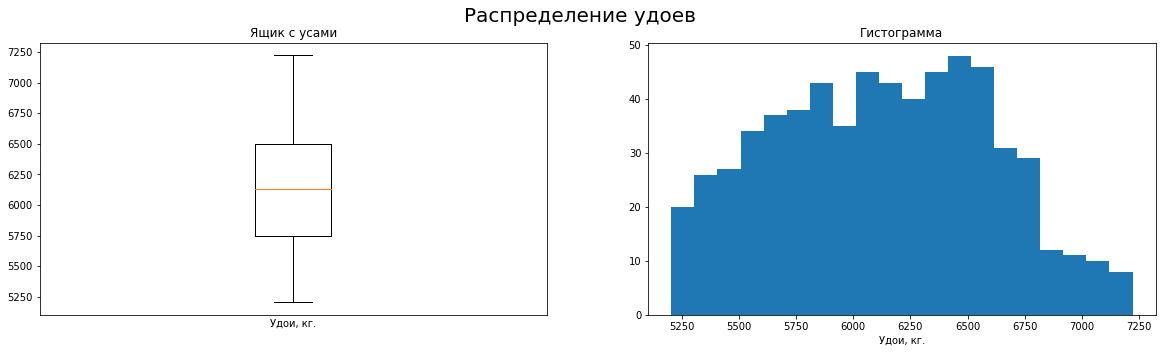

In [25]:
plot_numeric(main, 'milk_kg', 'Распределение удоев', 'Удои, кг.', 20)

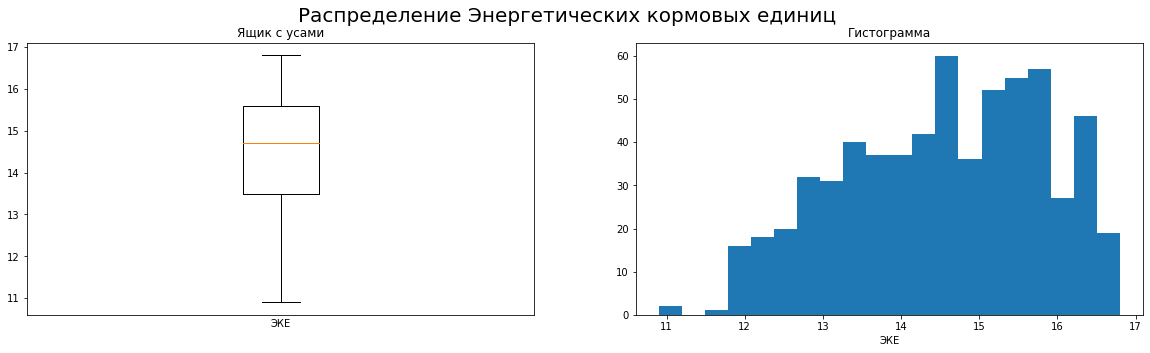

In [26]:
plot_numeric(
    main, 'eke', 'Распределение Энергетических кормовых единиц', 'ЭКЕ', 20
)

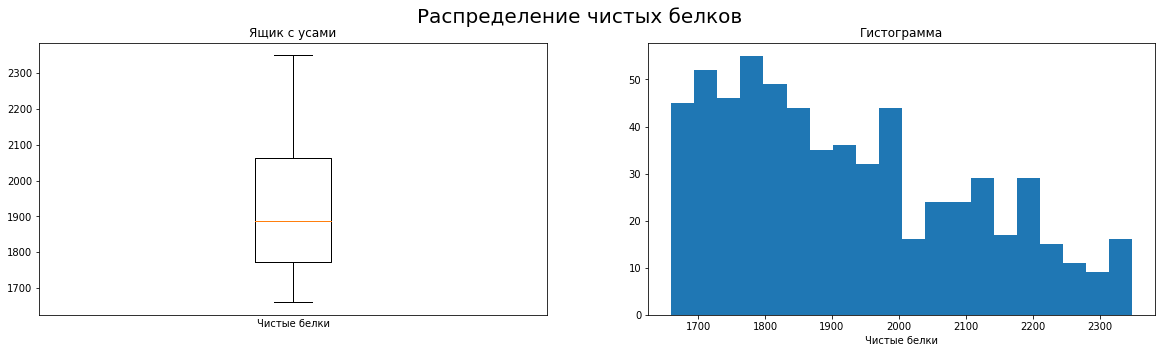

In [27]:
plot_numeric(
    main, 'protein_g', 'Распределение чистых белков', 'Чистые белки', 20
)

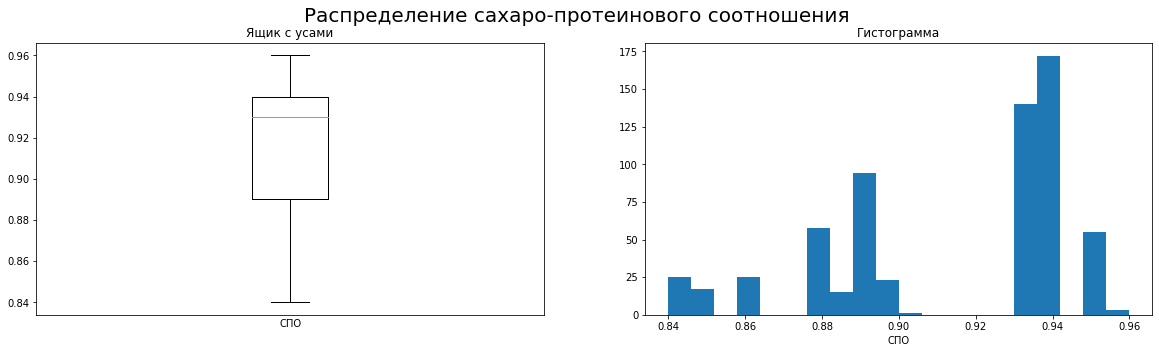

In [28]:
plot_numeric(
    main, 'spo', 'Распределение сахаро-протеинового соотношения', 'СПО', 20
)

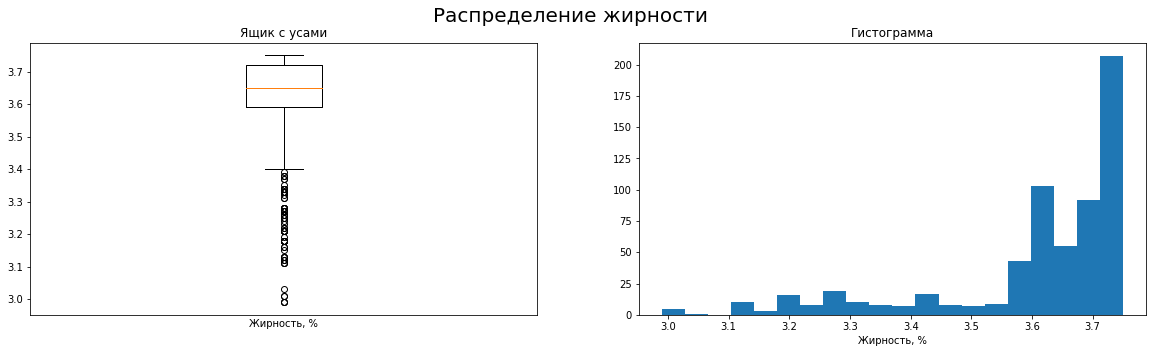

In [29]:
plot_numeric(main, 'fat_share', 'Распределение жирности', 'Жирность, %', 20)

Боксплот показывает нам обилие статистических выбросов, но здравый смысл подсказывает, что в молоке 3% жирности нет ничего особенного.

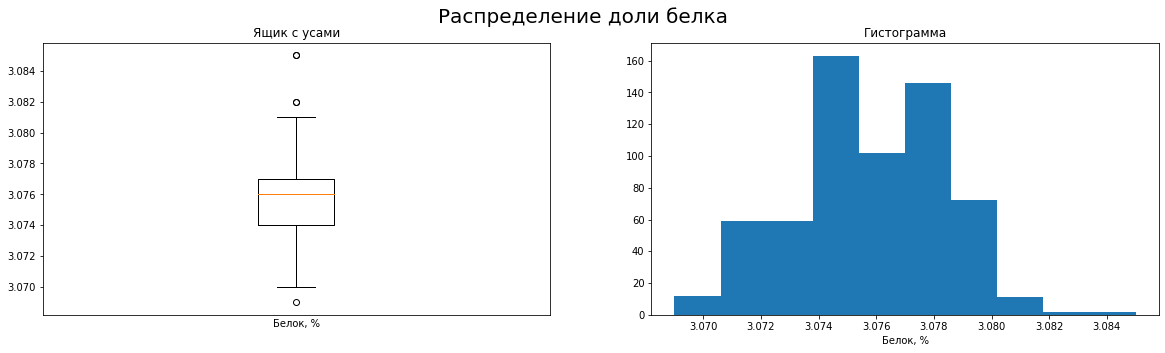

In [30]:
plot_numeric(main, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

Разница между 3.07 и 3.082 не настолько существенна, чтобы избавляться от этих данных как от выбросов.

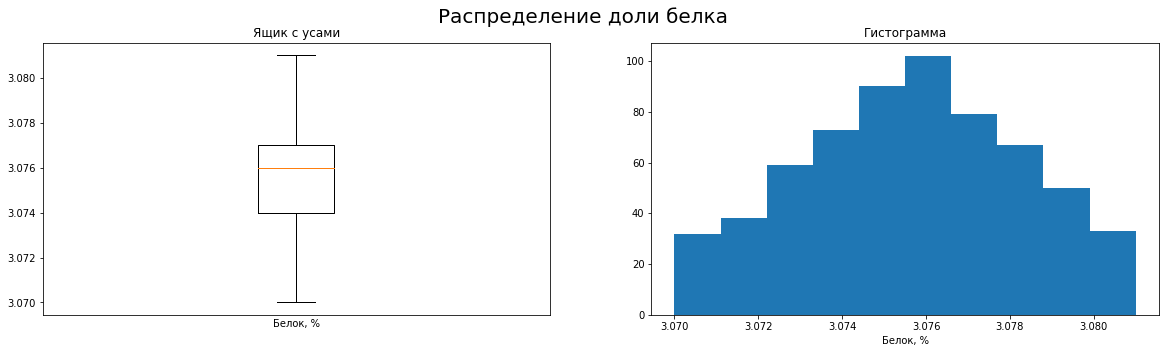

In [31]:
main = main[(main['protein_share'] >= 3.07) & (main['protein_share'] <= 3.081)]

plot_numeric(main, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

### dad - категориальные признаки

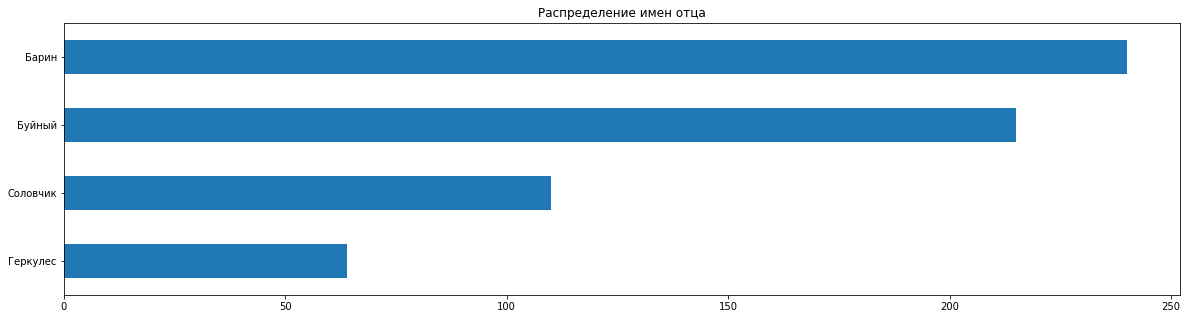

In [32]:
dad['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имен отца')
plt.show()

### cow - категориальные признаки

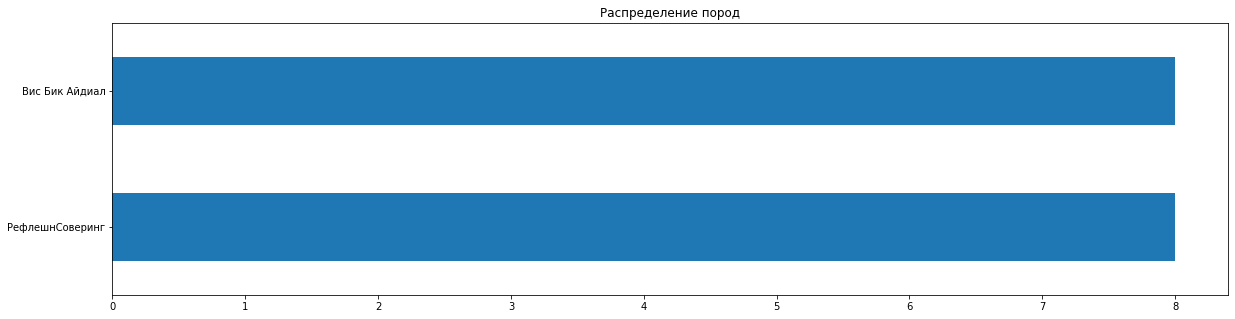

In [33]:
cow['cow_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пород')
plt.show()

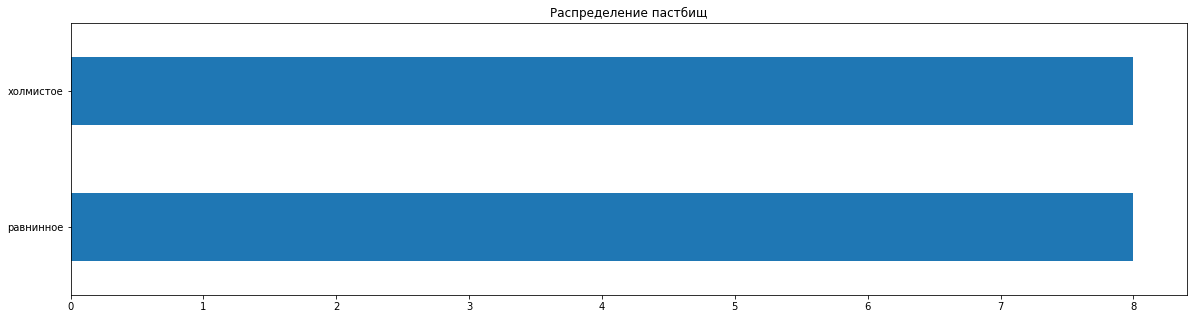

In [34]:
cow['pasture_type'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение пастбищ')
plt.show()

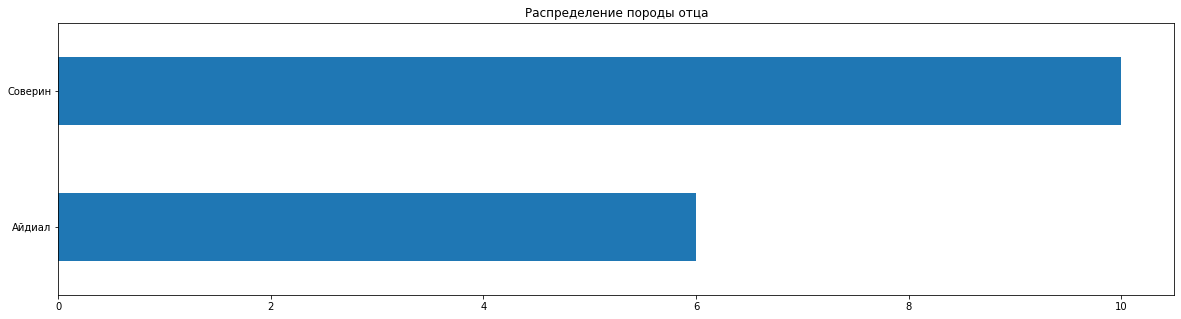

In [35]:
cow['dad_breed'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение породы отца')
plt.show()

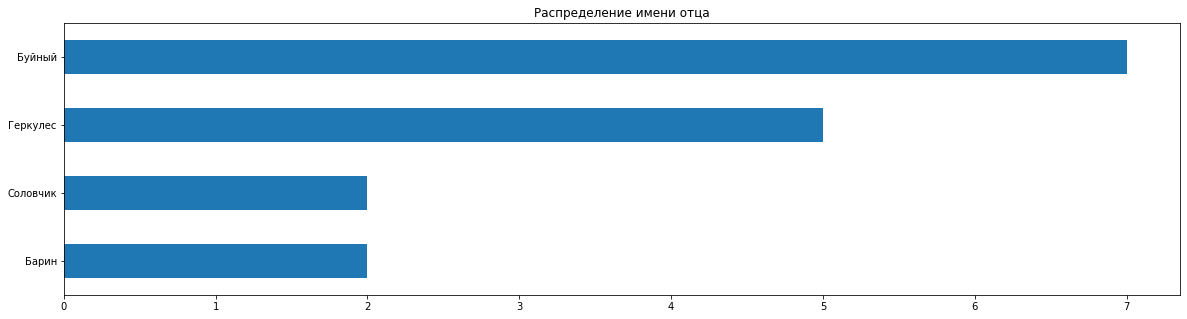

In [36]:
cow['dad_name'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение имени отца')
plt.show()

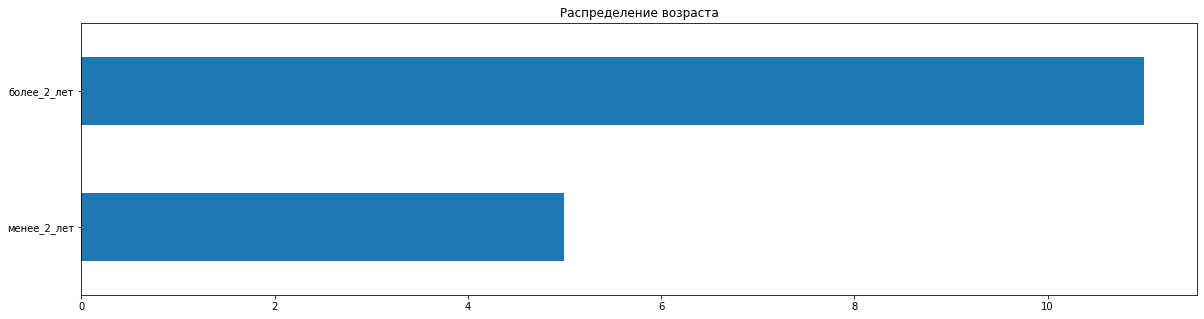

In [37]:
cow['age'].value_counts().sort_values().plot.barh(figsize=(20, 5))
plt.title('Распределение возраста')
plt.show()

### cow - количественные переменные

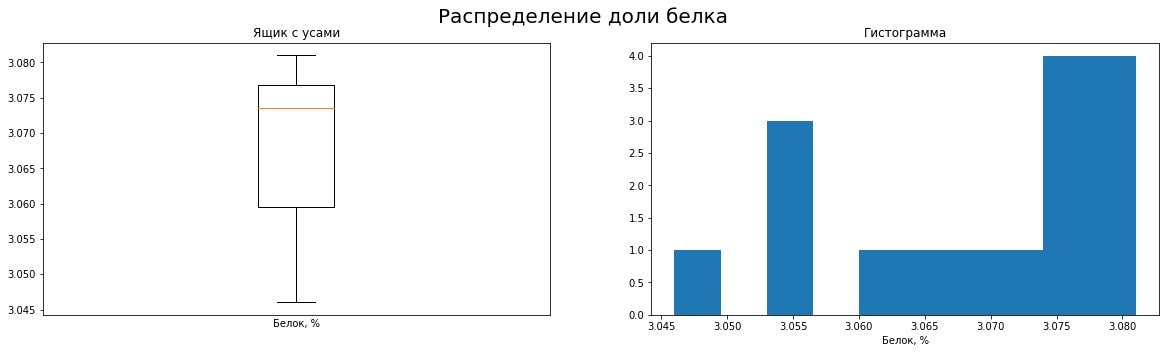

In [38]:
plot_numeric(cow, 'protein_share', 'Распределение доли белка', 'Белок, %', 10)

**Промежуточный вывод:**

Нам удалось посмотреть на распределение данных и провести дополнительные корректировки. 
- Мы избавились от неявных дублей в датасете main;
- Избавились от выбросов там, где это было возможно;
- Количественные переменные зачастую распределены ненормально.

<a id='corr'></a>
## Корреляционный анализ

In [39]:
# Корреляция между переменными, распределёнными нормально
main[['milk_kg', 'protein_share']].corr('pearson')

,milk_kg,protein_share
milk_kg,1.000000,0.002288
protein_share,0.002288,1.000000


In [40]:
# Корреляция между переменными, распределёнными ненормально
main.drop(['protein_share', 'id'], axis=1).corr('spearman')

,milk_kg,eke,protein_g,spo,fat_share
milk_kg,1.000000,0.764683,0.437322,0.786345,0.687403
eke,0.764683,1.000000,0.383890,0.741703,0.686893
protein_g,0.437322,0.383890,1.000000,0.488510,0.395221
spo,0.786345,0.741703,0.488510,1.000000,0.699486
fat_share,0.687403,0.686893,0.395221,0.699486,1.000000


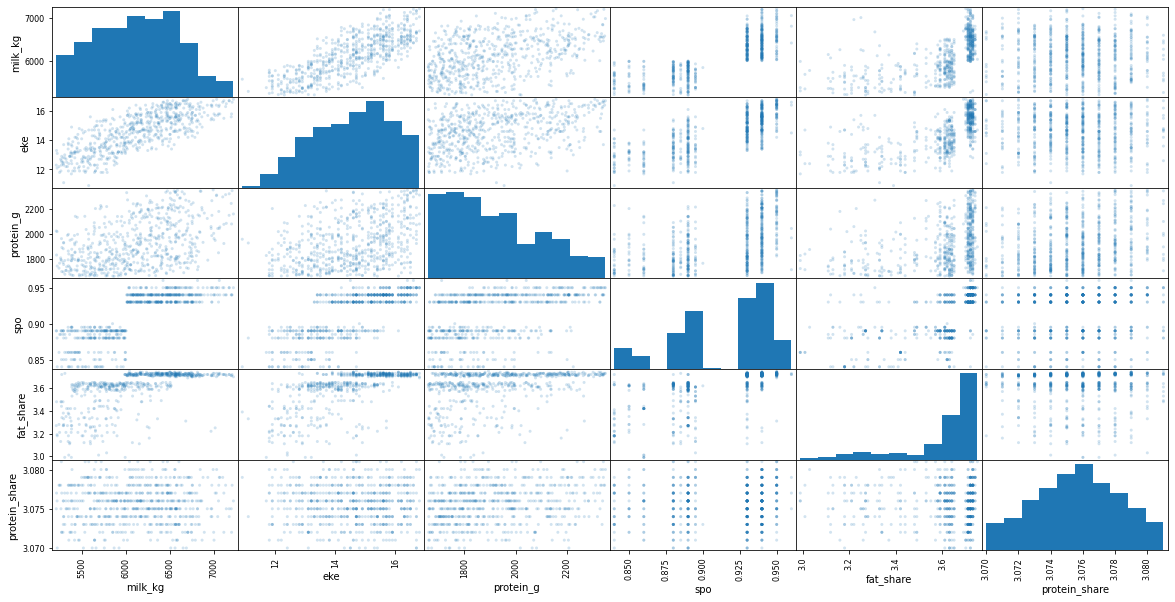

In [41]:
pd.plotting.scatter_matrix(
    main.drop(['id'], axis=1), alpha=0.2, figsize=(20, 10)
)
plt.show()

**Промежуточный вывод:**

Больше всего с целевой переменной коррелируют характеристики корма: ЭКЕ, количество граммов чистого протеина и СПО. 

<a id='processing'></a>
## Выбор коров

### Подготовка данных

Нужно избавиться от переменных, которые не могут повлиять на удой. Это в первую очередь характеристики молока. Характеристики корма, порода отца и тип пастбища уже могут повлиять на удой. Их оставим и закодируем.

In [42]:
main_for_learning = main.copy()

Категориальные признаки представлены всего в двух экземплярах. Можно закодировать их как бинарные. Можно использовать one_hot_encoder, чтобы преобразовать категориальные признаки.

**Разбивка на выборки**

In [43]:
X = main_for_learning.reset_index().drop(
    ['milk_kg', 'index', 'id', 'taste', 'protein_share', 'fat_share'], axis=1
)
y = main_for_learning.reset_index().drop(['index'], axis=1)['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


In [44]:
enc = OneHotEncoder(drop='first')

In [45]:
cat_X_train = enc.fit_transform(
    X_train[['cow_breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

cat_X_test = enc.transform(
    X_test[['cow_breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()
# делаем преобразование и смотрим на получившиеся названия столбцов,
# чтобы правильно переименовать
enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет'], dtype=object)

In [46]:
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)
display(cat_X_train_df.head())
cat_X_train_df.shape

,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


(467, 4)

In [47]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)
display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,age,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.6,1966,0.96,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,0.0,1.0,0.0,0.0
1,16.4,1894,0.94,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0
2,14.1,1977,0.89,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0
3,13.4,1775,0.88,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,1.0,0.0,0.0,0.0
4,14.7,1671,0.88,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,0.0,0.0,0.0


(467, 11)

In [48]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age'], axis=1
)

display(X_train_for_learning.head())
X_train_for_learning.shape

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,16.6,1966,0.96,0.0,1.0,0.0,0.0
1,16.4,1894,0.94,0.0,0.0,0.0,0.0
2,14.1,1977,0.89,0.0,0.0,0.0,0.0
3,13.4,1775,0.88,1.0,0.0,0.0,0.0
4,14.7,1671,0.88,0.0,0.0,0.0,0.0


(467, 7)

**Трансформация выборок**

In [49]:
num_cols = ['eke', 'protein_g', 'spo']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
]

**Стандартизация количественных колонок**

In [50]:
scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

In [51]:
X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,1.543027,0.206082,1.426018,0.0,1.0,0.0,0.0
1,1.388625,-0.185338,0.795084,0.0,0.0,0.0,0.0
2,-0.386997,0.265882,-0.782250,0.0,0.0,0.0,0.0
3,-0.927403,-0.832267,-1.097716,1.0,0.0,0.0,0.0
4,0.076209,-1.397651,-1.097716,0.0,0.0,0.0,0.0


Train (467, 7)


,eke,protein_g,spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years
0,-0.695800,0.091918,-0.782250,1.0,1.0,1.0,0.0
1,-2.085417,-1.446578,-2.359584,0.0,1.0,0.0,1.0
2,1.465826,0.836702,0.795084,0.0,0.0,1.0,0.0
3,-0.541398,-1.066031,-1.097716,0.0,1.0,1.0,0.0
4,0.925419,-1.158450,0.479618,0.0,1.0,1.0,0.0


Test (156, 7)


In [52]:
def model_test(X_train, y_train, X_test, y_test, linear_model):
    '''Обучает и тестирует модель. Выводит r2 и график распределения остатков.
    Возвращает обученную модель'''

    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    print(f'R2 score: {r2}')

    plt.scatter(y_pred, y_test)
    plt.title('График остатков')
    plt.xlabel('Прогнозные значения модели')
    plt.ylabel('Реальные значения')
    plt.show()

    return linear_model

### Обучение и тест модели линейной регрессии

R2 score: 0.7832029531509055


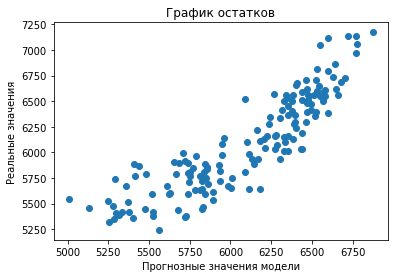

In [53]:
linear_model = LinearRegression()

model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

R2 ближе к единице, чем к минус бесконечности - это говорит и неплохом качестве модели. Остатки распределены неравномерно. Наблюдается линейная зависимость с убывающей дисперсией.

<a id='feature'></a>
## Обогащение данных

**Исключение зависимостей**

Графики показывают, что СПО и Удой связаны нелинейно. Исключим нелинейность: переведём СПО в категориальный признак, выявив и использовав границу нелинейности.

In [54]:
main_for_learning.loc[:, 'is_high_spo'] = (
    main_for_learning.loc[:, 'spo'] > 0.92
) * 1.0

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0


ЭКЕ и Удой также связаны нелинейно. Исключим нелинейность: введём новый признак «ЭКЕ в квадрате».

In [55]:
main_for_learning.loc[:, 'eke2'] = main_for_learning.loc[:, 'eke'] ** 2

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84


**Разбивка на выборки, стандартизация количественных переменных и преобразование категориальных**

In [56]:
X = main_for_learning.drop(
    ['milk_kg', 'id', 'taste', 'protein_share', 'fat_share', 'eke', 'spo'],
    axis=1,
)
y = main_for_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


In [57]:
num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
]

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(
    X_train[['cow_breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

cat_X_test = enc.transform(
    X_test[['cow_breed', 'dad_breed', 'pasture_type', 'age']]
).toarray()

In [58]:
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
    ],
)

# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)


X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

In [59]:
# Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,1.626057,0.206082,0.0,1.0,0.0,0.0,1.0
1,1.449208,-0.185338,0.0,0.0,0.0,0.0,1.0
2,-0.430475,0.265882,0.0,0.0,0.0,0.0,0.0
3,-0.946283,-0.832267,1.0,0.0,0.0,0.0,0.0
4,0.032546,-1.397651,0.0,0.0,0.0,0.0,0.0


Train (467, 7)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo
0,-0.728438,0.091918,1.0,1.0,1.0,0.0,0.0
1,-1.963160,-1.446578,0.0,1.0,0.0,1.0,0.0
2,1.537365,0.836702,0.0,0.0,1.0,0.0,1.0
3,-0.580528,-1.066031,0.0,1.0,1.0,0.0,0.0
4,0.931525,-1.158450,0.0,1.0,1.0,0.0,1.0


Test (156, 7)


**Тест модели на новых выборках**

R2 score: 0.8347436421181886


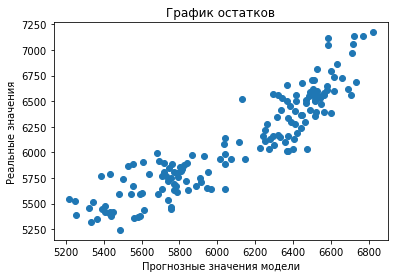

In [60]:
model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

R2 удалось увеличить до 0.83. Качество модели улучшилось.

**Обогащение данных именем папы**

Данные можно обогатить признаком "Имя папы". Попробуем.

In [61]:
main_for_learning = main_for_learning.merge(dad)

main_for_learning.head()

,id,milk_kg,eke,protein_g,spo,cow_breed,pasture_type,dad_breed,fat_share,protein_share,taste,age,is_high_spo,eke2,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0.0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0.0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0.0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0.0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0.0,163.84,Барин


In [62]:
X = main_for_learning.drop(
    ['milk_kg', 'id', 'taste', 'protein_share', 'fat_share', 'eke', 'spo'],
    axis=1,
)
y = main_for_learning['milk_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

print(
    f'''X_train nrows: {X_train.shape[0]} ({round(X_train.shape[0] / X.shape[0] * 100)}%)
X_test nrows:  {X_test.shape[0]} ({round(X_test.shape[0] / X.shape[0] * 100)}%)'''
)

num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
    'dad_name',
]

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(
    X_train[['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

cat_X_test = enc.transform(
    X_test[['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

enc.get_feature_names()

X_train nrows: 467 (75%)
X_test nrows:  156 (25%)


array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [63]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

In [64]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,cow_breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,Вис Бик Айдиал,равнинное,Соверин,более_2_лет,1.0,275.56,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,1.0,268.96,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,198.81,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,РефлешнСоверинг,равнинное,Айдиал,более_2_лет,0.0,179.56,Геркулес,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,Вис Бик Айдиал,равнинное,Айдиал,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 15)


,protein_g,cow_breed,pasture_type,dad_breed,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,РефлешнСоверинг,холмистое,Соверин,более_2_лет,0.0,187.69,Барин,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,Вис Бик Айдиал,равнинное,Соверин,менее_2_лет,0.0,141.61,Барин,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,Вис Бик Айдиал,холмистое,Айдиал,более_2_лет,1.0,272.25,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,Вис Бик Айдиал,холмистое,Соверин,более_2_лет,0.0,193.21,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,Вис Бик Айдиал,холмистое,Соверин,более_2_лет,1.0,249.64,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 15)


In [65]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,1.0,275.56,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,1.0,268.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,0.0,198.81,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,0.0,179.56,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 10)


,protein_g,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,0.0,187.69,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,0.0,141.61,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,1.0,272.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,0.0,193.21,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,1.0,249.64,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 10)


In [66]:
num_cols = ['eke2', 'protein_g']
cat_cols = [
    'is_sovering_breed',
    'is_sovering_dad',
    'is_hill_pasture',
    'is_younger_2_years',
    'is_high_spo',
    'is_furious',
    'is_hercules',
    'is_nightingale',
]

In [67]:
# Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num,
    columns=num_cols,
    index=X_train_for_learning.index,
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols, index=X_test_for_learning.index
)

X_train_for_learning = X_train_for_learning_num.merge(
    X_train_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

X_test_for_learning = X_test_for_learning_num.merge(
    X_test_for_learning[cat_cols],
    how='left',
    left_index=True,
    right_index=True,
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,1.626057,0.206082,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.449208,-0.185338,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.430475,0.265882,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.946283,-0.832267,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.032546,-1.397651,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 10)


,eke2,protein_g,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_high_spo,is_furious,is_hercules,is_nightingale
0,-0.728438,0.091918,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.963160,-1.446578,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.537365,0.836702,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.580528,-1.066031,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.931525,-1.158450,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


Test (156, 10)


R2 score: 0.8413986635664519


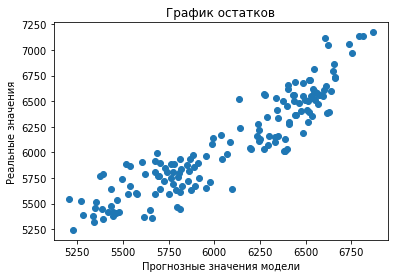

In [68]:
model = model_test(
    X_train_for_learning, y_train, X_test_for_learning, y_test, linear_model
)

Добавив имена отцов, удалось ещё немного улучшить модель.

<a id='linreg'></a>
### Прогнозы удоев для новых коров

**Подготовка новых данных**

In [69]:
display(cow.head())
print(f'''New: {cow.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


New: (16, 7)


Добавим планируемые показатели корма

In [70]:
cow['eke2'] = (main_for_learning['eke'].median() * 1.05) ** 2
cow['protein_g'] = main_for_learning['protein_g'].median() * 1.05
cow['is_high_spo'] = ((main_for_learning['spo'].median() * 1.05) > 0.92) * 1.0

# отложим обогащенные данные, пригодятся для логистической регрессии
cow_log = cow.copy()

display(cow.head())
print(f'''New: {cow.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,238.239225,1982.4,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,238.239225,1982.4,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,238.239225,1982.4,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,238.239225,1982.4,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,238.239225,1982.4,1.0


New: (16, 10)


In [71]:
# Кодируем категориальные
cow_cat = enc.transform(
    cow[['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']]
).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [72]:
cow_cat_df = pd.DataFrame(
    cow_cat,
    columns=[
        'is_sovering_bread',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cow_cat_df.head()

,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [73]:
# Стандартизируем количественные данные
cow_num = scaler.transform(cow[['eke2', 'protein_g']])


cow.loc[:, ['eke2', 'protein_g']] = pd.DataFrame(
    cow_num, columns=['eke2', 'protein_g']
)

display(cow.head())
print(f'''New: {cow.shape}''')

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.626039,0.295239,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.626039,0.295239,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.626039,0.295239,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.626039,0.295239,1.0


New: (16, 10)


In [74]:
# Соединяем данные

cow_final = cow.merge(cow_cat_df, left_index=True, right_index=True)

In [75]:
cow_final = cow_final.drop(
    [
        'cow_breed',
        'pasture_type',
        'dad_breed',
        'dad_name',
        'fat_share',
        'protein_share',
        'age',
    ],
    axis=1,
)


display(cow_final.head())
print(f'''New: {cow_final.shape}''')

,eke2,protein_g,is_high_spo,is_sovering_bread,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.626039,0.295239,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.626039,0.295239,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.626039,0.295239,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.626039,0.295239,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.626039,0.295239,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


New: (16, 10)


In [76]:
# Предсказываем
predict = model.predict(cow_final)

In [77]:
cow_predict = cow.copy()

In [78]:
cow_predict['milk_predict'] = predict

**Список коров, которых можно купить, согласно прогнозу**

In [79]:
cow_predict[cow_predict['milk_predict'] >= 6000]

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0,6040.460911
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.626039,0.295239,1.0,6609.662959
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.626039,0.295239,1.0,6042.298904
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.626039,0.295239,1.0,6240.793382
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,0.626039,0.295239,1.0,6706.037762
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,0.626039,0.295239,1.0,6246.181499
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,0.626039,0.295239,1.0,6405.780363
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,0.626039,0.295239,1.0,6342.556303
10,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,0.626039,0.295239,1.0,6040.460911
11,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.626039,0.295239,1.0,6101.035371


### Промежуточный итог:

Нам удалось построить алгоритм обработки и подготовки данных для модели, обучить модель и получить прогнозы для удоев коров с фермы. В дальнейшем эту модель можно будет использовать и для покупки новых коров, обогащая её данными поступивших. 

R2 = 84%

<a id='logreg'></a>
## Вкус молока

На вкус молока точно не будут влиять идентификаторы коров и удои. Остальные признаки в принципе могут повлиять на вкус.

**Разбивка на выборки**

Закодируем целевой признак бинарно

In [80]:
main_for_learning['taste'] = (main_for_learning['taste'] == 'вкусно') * 1.0

In [81]:
X = main_for_learning.drop(['id', 'milk_kg', 'eke', 'taste', 'spo'], axis=1)
y = main_for_learning['taste']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

In [82]:
X_train.head()

,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name
188,1966,Вис Бик Айдиал,равнинное,Соверин,3.73,3.077,более_2_лет,1.0,275.56,Барин
208,1894,Вис Бик Айдиал,равнинное,Айдиал,3.72,3.074,более_2_лет,1.0,268.96,Буйный
137,1977,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.078,более_2_лет,0.0,198.81,Буйный
268,1775,РефлешнСоверинг,равнинное,Айдиал,3.63,3.071,более_2_лет,0.0,179.56,Геркулес
581,1671,Вис Бик Айдиал,равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный


In [83]:
num_cols = ['eke2', 'protein_g', 'fat_share', 'protein_share']
cat_cols = ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name']

# Кодируем категориальные переменные и переименовываем колонки
# Кроме is_high_spo, она уже закодирована

enc = OneHotEncoder(drop='first')

cat_X_train = enc.fit_transform(X_train[cat_cols]).toarray()

cat_X_test = enc.transform(X_test[cat_cols]).toarray()

enc.get_feature_names()

array(['x0_РефлешнСоверинг', 'x1_Соверин', 'x2_холмистое',
       'x3_менее_2_лет', 'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'],
      dtype=object)

In [84]:
# Переименовываем столбцы
cat_X_train_df = pd.DataFrame(
    cat_X_train,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cat_X_test_df = pd.DataFrame(
    cat_X_test,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

In [85]:
# Соединяем закодированные колонки с общим датасетом
X_train = X_train.reset_index().drop(['index'], axis=1)
X_train_for_learning = X_train.merge(
    cat_X_train_df, left_index=True, right_index=True
)

X_test = X_test.reset_index().drop(['index'], axis=1)
X_test_for_learning = X_test.merge(
    cat_X_test_df, left_index=True, right_index=True
)

display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,Вис Бик Айдиал,равнинное,Соверин,3.73,3.077,более_2_лет,1.0,275.56,Барин,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,Вис Бик Айдиал,равнинное,Айдиал,3.72,3.074,более_2_лет,1.0,268.96,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.078,более_2_лет,0.0,198.81,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,РефлешнСоверинг,равнинное,Айдиал,3.63,3.071,более_2_лет,0.0,179.56,Геркулес,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,Вис Бик Айдиал,равнинное,Айдиал,3.18,3.079,более_2_лет,0.0,216.09,Буйный,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 17)


,protein_g,cow_breed,pasture_type,dad_breed,fat_share,protein_share,age,is_high_spo,eke2,dad_name,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,РефлешнСоверинг,холмистое,Соверин,3.63,3.078,более_2_лет,0.0,187.69,Барин,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,Вис Бик Айдиал,равнинное,Соверин,3.28,3.074,менее_2_лет,0.0,141.61,Барин,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,Вис Бик Айдиал,холмистое,Айдиал,3.71,3.075,более_2_лет,1.0,272.25,Геркулес,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,Вис Бик Айдиал,холмистое,Соверин,3.64,3.073,более_2_лет,0.0,193.21,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,Вис Бик Айдиал,холмистое,Соверин,3.73,3.078,более_2_лет,1.0,249.64,Барин,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 17)


In [86]:
# Избавляемся от лишних колонок
X_train_for_learning = X_train_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

X_test_for_learning = X_test_for_learning.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)
display(X_train_for_learning.head())
print(f'Train {X_train_for_learning.shape}')

display(X_test_for_learning.head())
print(f'Test {X_test_for_learning.shape}')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1966,3.73,3.077,1.0,275.56,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1894,3.72,3.074,1.0,268.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1977,3.58,3.078,0.0,198.81,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1775,3.63,3.071,0.0,179.56,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1671,3.18,3.079,0.0,216.09,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train (467, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,1945,3.63,3.078,0.0,187.69,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1662,3.28,3.074,0.0,141.61,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2082,3.71,3.075,1.0,272.25,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1732,3.64,3.073,0.0,193.21,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1715,3.73,3.078,1.0,249.64,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test (156, 12)


In [87]:
# Стандартизация

scaler = StandardScaler()

X_train_for_learning_num = scaler.fit_transform(X_train_for_learning[num_cols])
X_train_for_learning_num = pd.DataFrame(
    X_train_for_learning_num, columns=num_cols
)

X_test_for_learning_num = scaler.transform(X_test_for_learning[num_cols])
X_test_for_learning_num = pd.DataFrame(
    X_test_for_learning_num, columns=num_cols
)

In [88]:
X_train_for_learning[num_cols] = X_train_for_learning_num
X_test_for_learning[num_cols] = X_test_for_learning_num

display(X_train_for_learning.head())
print(f'''Train: {X_train_for_learning.shape}''')

display(X_test_for_learning.head())
print(f'''Test: {X_test_for_learning.shape}''')

,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.206082,0.727262,0.550740,1.0,1.626057,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.185338,0.665466,-0.656751,1.0,1.449208,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.265882,-0.199680,0.953236,0.0,-0.430475,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.832267,0.109301,-1.864241,0.0,-0.946283,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.397651,-2.671524,1.355733,0.0,0.032546,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train: (467, 12)


,protein_g,fat_share,protein_share,is_high_spo,eke2,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,0.091918,0.109301,0.953236,0.0,-0.728438,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,-1.446578,-2.053563,-0.656751,0.0,-1.963160,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.836702,0.603670,-0.254254,1.0,1.537365,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.066031,0.171097,-1.059247,0.0,-0.580528,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.158450,0.727262,0.953236,1.0,0.931525,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Test: (156, 12)


**Обучение и тест модели**

In [89]:
logistic_model = LogisticRegression(random_state=RANDOM_STATE)

In [90]:
# Обучаем
logistic_model.fit(X_train_for_learning, y_train)

# Предсказываем
y_pred = logistic_model.predict(X_test_for_learning)

In [91]:
# Считаем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(
    f'''Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}'''
)

confusion_matrix(y_test, y_pred)

Accuracy: 0.6153846153846154
Precision: 0.6216216216216216
Recall: 0.7931034482758621


array([[27, 42],
       [18, 69]])

In [92]:
y_proba = logistic_model.predict_proba(X_test_for_learning)

In [93]:
data = pd.DataFrame(
    {'y_valid': y_test.to_numpy(), 'y_pred': y_pred, 'y_proba': y_proba[:, 1]}
)
data.head()

,y_valid,y_pred,y_proba
0,1.0,1.0,0.716267
1,0.0,0.0,0.287427
2,1.0,1.0,0.816418
3,0.0,1.0,0.675481
4,1.0,1.0,0.766379


In [94]:
# Ищем порог, при котором получаем ложно-положительные срабатывания
data[(data['y_valid'] == 0.0) & (data['y_pred'] == 1.0)]['y_proba'].max()

0.8087736431349019

Дополним функцию предсказаний.

In [95]:
threshold = 0.809

In [96]:
y_pred_upgraded = (y_proba[:, 1] >= threshold) * 1

In [97]:
precision_score(y_test, y_pred_upgraded)

1.0

**Подготовка новых данных**

In [98]:
cow_log.head()

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,238.239225,1982.4,1.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,238.239225,1982.4,1.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,238.239225,1982.4,1.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,238.239225,1982.4,1.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,238.239225,1982.4,1.0


In [99]:
cow_cat = enc.transform(cow_log[cat_cols]).toarray()

cow_cat_df = pd.DataFrame(
    cow_cat,
    columns=[
        'is_sovering_breed',
        'is_sovering_dad',
        'is_hill_pasture',
        'is_younger_2_years',
        'is_furious',
        'is_hercules',
        'is_nightingale',
    ],
)

cow_log = cow_log.reset_index().drop(['index'], axis=1)
cow_log = cow_log.merge(cow_cat_df, left_index=True, right_index=True)

cow_log = cow_log.drop(
    ['cow_breed', 'dad_breed', 'pasture_type', 'age', 'dad_name'], axis=1
)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,3.58,3.076,238.239225,1982.4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3.54,3.081,238.239225,1982.4,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,3.59,3.074,238.239225,1982.4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.40,3.061,238.239225,1982.4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3.64,3.074,238.239225,1982.4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [100]:
# Стандартизация
cow_num = scaler.transform(cow_log[num_cols])
cow_log[num_cols] = pd.DataFrame(cow_num, columns=num_cols)

cow_log.head()

,fat_share,protein_share,eke2,protein_g,is_high_spo,is_sovering_breed,is_sovering_dad,is_hill_pasture,is_younger_2_years,is_furious,is_hercules,is_nightingale
0,-0.199680,0.148243,0.626039,0.295239,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.446864,2.160727,0.626039,0.295239,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,-0.137883,-0.656751,0.626039,0.295239,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.312010,-5.889209,0.626039,0.295239,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.171097,-0.656751,0.626039,0.295239,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Применяем модель к новым данным

In [101]:
y_proba = logistic_model.predict_proba(cow_log)

In [102]:
y_proba

array([[0.15884929, 0.84115071],
       [0.21409625, 0.78590375],
       [0.25083578, 0.74916422],
       [0.25235051, 0.74764949],
       [0.24350585, 0.75649415],
       [0.43582344, 0.56417656],
       [0.20145992, 0.79854008],
       [0.19727323, 0.80272677],
       [0.2691404 , 0.7308596 ],
       [0.28649588, 0.71350412],
       [0.24569128, 0.75430872],
       [0.16277016, 0.83722984],
       [0.23589205, 0.76410795],
       [0.17736461, 0.82263539],
       [0.39369403, 0.60630597],
       [0.29550129, 0.70449871]])

In [103]:
cow_predict['is_tasty'] = y_proba[:, 1] > 0.809

## Результат

Фермер может купить только двух коров с индексами 0 и 11

In [104]:
cow_predict[
    (cow_predict['is_tasty'] == True) & (cow_predict['milk_predict'] >= 6000)
]

,cow_breed,pasture_type,dad_breed,dad_name,fat_share,protein_share,age,eke2,protein_g,is_high_spo,milk_predict,is_tasty
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.626039,0.295239,1.0,6040.460911,True
11,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.626039,0.295239,1.0,6101.035371,True


<a id='summary'></a>
## Общий вывод

**Что мы сделали:**

- Удалили явные и неявные дубликаты;
- Визуально оценили распределение переменных;
- Обогатили набор данных для обучения;
- Выявили нелинейные зависимости некоторых переменных;
- Ввели новые фичи, которые помогли улучшить модели;
- Предказали удои с помощью модели линейной регрессии;
- Предсказали вкус молока с помощью модели логистической регрессии;
- Выяснили, каких коров стоит купить нашему заказчику.

**Выводы:**

- На удои больше всего влияют показатели корма: ЭКЕ, СПО и содержание белка;
- На вкус молока - показатели самого молока: содержание белка и жирность;
- С нашими моделями заказчик сможет рассмотреть нескольких фермеров и собрать себе *идеальное* стадо.